# **Mask R-CNN Instance Based Image Segmentation**

**Code:** Mask R-CNN for object detection and instance segmentation on Keras and TensorFlow, Waleed Abdulla, 2017, https://github.com/matterport/Mask_RCNN

**Paper:** K. He, G. Gkioxari, P. Dollár and R. Girshick, "Mask R-CNN," 2017 IEEE International Conference on Computer Vision (ICCV), Venice, 2017, pp. 2980-2988, doi: 10.1109/ICCV.2017.322.


In [1]:
# !pip install -r ./root/Mask_RCNN/requirements.txt

## Import Libraries and Mount Drive

In [2]:
import warnings
import logging
warnings.filterwarnings("ignore")

In [3]:
import os,cv2
from skimage import io
from tqdm import tqdm
from scipy import stats
import shutil
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.measure import label, regionprops
import tensorflow as tf
from keras.models import *
import keras
logging.getLogger('tensorflow').setLevel(logging.ERROR)

from imgaug import augmenters as iaa
from datetime import timedelta
import datetime
import imageio
import math
import pytz
from pytz import timezone
import imagecodecs._imcd
from tifffile import imread

from root.Mask_RCNN.mrcnn.config import Config
from root.Mask_RCNN.mrcnn import utils
from root.Mask_RCNN.mrcnn import model as modellib
from root.Mask_RCNN.mrcnn import visualize
from root.Mask_RCNN.mrcnn import postprocessing
from root.Mask_RCNN.mrcnn.model import log
import nucleus

Using TensorFlow backend.


In [4]:
def gamma_img(gamma, img):
    gamma_cvt = np.zeros((256,1), dtype=np.uint8)
    for i in range(256):
        gamma_cvt[i][0] = 255*(float(i)/255)**(1.0/gamma)
    return cv2.LUT(img, gamma_cvt)

def reject_outliers(data, m=2):
    JoeGreen = np.mean(data)
    STD = np.std(data)
    data[(data -JoeGreen) > m*STD] = 0
    return data

# 1. Load and Process Images

In [5]:
path_home = "/home/acd13264yb/DDDog/Datasets/240420Rettsyndrome/deconv/"

Chip_status = ["H3K27ac", "CTCF", "Dapi"]

path_chip = ["ctrl/CTRL HiPSC_1_Dapi_488_CTCF_555H3K27AC006 - Deconvolved 3 iterations, Type Richardson-Lucy_XY001.tif",
             "rett/HPS3042_1_Dapi_488_CTCF_555H3K27AC - Deconvolved 3 iterations, Type Richardson-Lucy_XY01.tif"]

## 1.1 Load Image

/home/acd13264yb/DDDog/Datasets/240420Rettsyndrome/deconv/ctrl/CTRL HiPSC_1_Dapi_488_CTCF_555H3K27AC006 - Deconvolved 3 iterations, Type Richardson-Lucy_XY001.tif


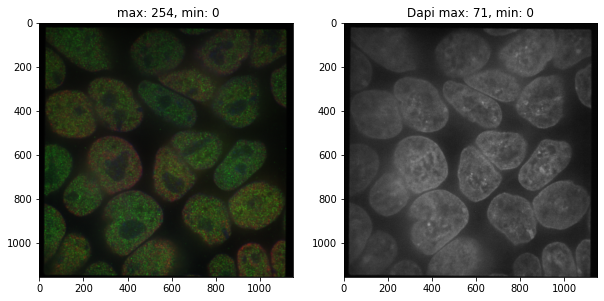

In [50]:
path = path_home+path_chip[0]
print(path)

img = io.imread(path)
b = img[:,:,2]
img_dapi = cv2.merge([b,b,b])

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title(" max: "+str(img.max())+", min: "+str(img.min()))
plt.imshow(img)

plt.subplot(1,2,2)
plt.title(str(Chip_status[2])+" max: "+str(img_dapi.max())+", min: "+str(img_dapi.min()))
img_dapi *= int(255/img_dapi.max())
plt.imshow(img_dapi)

## 1.2 Denoise using UNet

In [51]:
# NW = '../../Datasets/weights/unet_noise_cell_line.hdf5'
# model = load_model(NW)

In [52]:
# img = cv2.resize(b, (512, 512), interpolation=cv2.INTER_CUBIC)
# img_new = np.asarray([img / 255.])
# img_new = np.expand_dims(img_new,3)

# result = model.predict(img_new)
# out = result[0,:,:,0]
# out = np.zeros(img_new.shape)
# out = 255*result[0,:,:,0].astype(np.uint8)
# imgDN = img - out
# imgDN[imgDN<0]=0
# imgDN = cv2.resize(imgDN, (2306, 2306), interpolation=cv2.INTER_CUBIC)

# plt.figure(figsize=(10,10))
# plt.subplot(1,3,1)
# plt.imshow(img)
# plt.subplot(1,3,2)
# plt.imshow(out)
# print(out.max())
# plt.subplot(1,3,3)
# plt.imshow(imgDN)

# 2. Configuration

In [53]:
class NucleusInferenceConfig(nucleus.NucleusConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MAX_DIM = 512

    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.3
    RPN_NMS_THRESHOLD = 0.2
    
    BACKBONE = "resnet50"
    
    MEAN_PIXEL = np.mean(img_dapi,axis=(0,1))
    
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (100, 100)

# 3. Run the Network

In [54]:
Weights = "Kaggle"

In [55]:
#Change weight paths if different.
if Weights == "coco":
    weights_path = '../../Datasets/weights/mask_rcnn_coco.h5' 
elif Weights == "imagenet":
    weights_path = model.get_imagenet_weights()
elif Weights == "Kaggle":
    weights_path = '../../Datasets/weights/mask_rcnn_kaggle_v1.h5' 
elif Weights == "Storm_Tissue":
    weights_path = '../../Datasets/weights/mask_rcnn_nucleus_tissue.h5' 
elif Weights == "Storm_Cell":
    weights_path = '../../Datasets/weights/mask_rcnn_nucleus_cell.h5' 
elif Weights == "Select":
    weights_path = '../../Datasets/weights/select_weight.h5' 

## 3.1 Run Network

In [56]:
# Configurations
config = NucleusInferenceConfig()

# Create model
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=weights_path)

if Weights == "coco":
    model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
else:
    model.load_weights(weights_path, by_name=True)
    
result = model.detect([img_dapi], verbose=0)[0]

Origin shape:  (1152, 1152, 3)
image                    shape: (1152, 1152, 3)       min:    0.00000  max:  213.00000  uint8
mask                     shape: (1152, 1152, 29)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (29,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (29, 4)               min:   22.00000  max: 1152.00000  int32


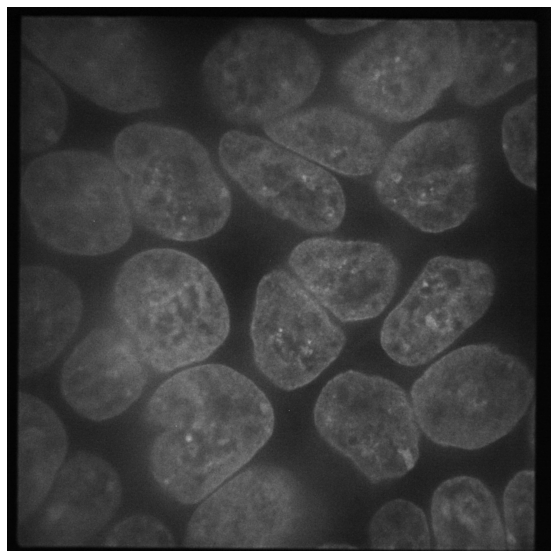

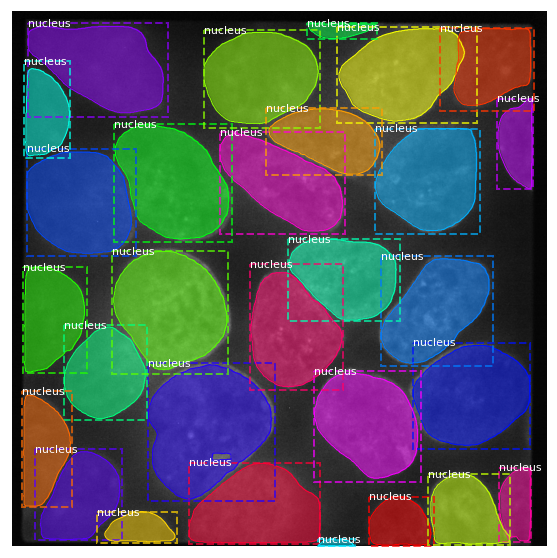

In [57]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img_dapi)

mask, bbox, class_ids = result["masks"], result["rois"], result["class_ids"]
print("Origin shape: ", img.shape)
log("image", img_dapi)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(img_dapi, bbox, mask, class_ids, ["BG","nucleus"], figsize=(10, 10))

## 4. post processing

In [58]:
def visual_cells(img, cells):
    F_total_boxes=[]
    F_total_masks=[]
    for cc in range(len(cells)):
        if cells[cc]:
            F_total_boxes.append(bbox[cc])
            F_total_masks.append(mask[:,:,cc])

    F_total_boxes = np.array(F_total_boxes)
    F_total_masks=np.transpose(np.array(F_total_masks),(1,2,0))
    F_total_class_ids=np.ones(F_total_boxes.shape[0], dtype=np.int32)
    print("total_boxes.shape: ",F_total_boxes.shape)
    print("total_masks.shape: ",F_total_masks.shape)
    visualize.display_instances(img, F_total_boxes, F_total_masks, F_total_class_ids, ["BG","nucleus"], figsize=(10,10))

### 4.1 remove outliers by roundness

In [59]:
def compute_roundness(label_image):
    contours, hierarchy = cv2.findContours(np.array(label_image, dtype=np.uint8), cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)
    a = cv2.contourArea(contours[0]) * 4 * math.pi
    b = math.pow(cv2.arcLength(contours[0], True), 2)
    if b == 0:
        return 0
    return a / b

len(total_roundness):  29
roundness_outliers: 
(True, 11, 0.6267271843944662, 0.92249522734852)
(True, 12, 0.5855235602566148, 1.2394906437662108)
(True, 22, 0.6165923885989322, 1.0004661311400205)
(True, 24, 0.38919172453141365, 2.7499473893559)
(True, 27, 0.6527729469403324, 0.7221151026167615)
(True, 28, 0.36118270729323493, 2.9654315917445526)
total_boxes.shape:  (6, 4)
total_masks.shape:  (1152, 1152, 6)


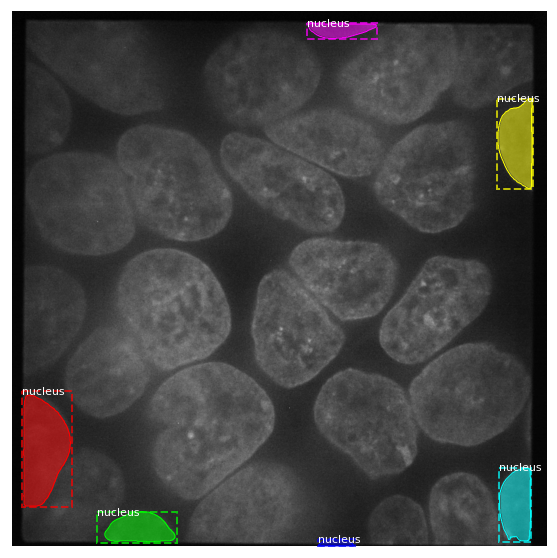

In [60]:
total_roundness=[]
for i in range(bbox.shape[0]):
    mmask = mask[:,:,i]
    total_roundness.append(compute_roundness(mmask))
print("len(total_roundness): ",len(total_roundness))

roundness_outliers = []
roundness_zscore = np.abs(stats.zscore(total_roundness))
for c in range(bbox.shape[0]):
    roundness_outliers.append((total_roundness[c])<0.68)
    
print("roundness_outliers: ")
for c in range(len(total_roundness)):
    if roundness_outliers[c]:
        print((roundness_outliers[c], c, total_roundness[c], roundness_zscore[c]))
visual_cells(img_dapi, roundness_outliers)

### 4.2 remove outliers by masks_area

len(total_masks_area):  29
masks_outliers: 
(True, 9, 11159, 1.1798477947380612)
(True, 11, 8713, 1.3581599041140526)
(True, 12, 10555, 1.2238790760394098)
(True, 13, 19088, 0.6018278784493307)
(True, 22, 17664, 0.7056367270803248)
(True, 23, 13982, 0.9740525842849037)
(True, 24, 3353, 1.748901075927345)
(True, 27, 7263, 1.4638641390262306)
(True, 28, 829, 1.932899344146888)
total_boxes.shape:  (9, 4)
total_masks.shape:  (1152, 1152, 9)


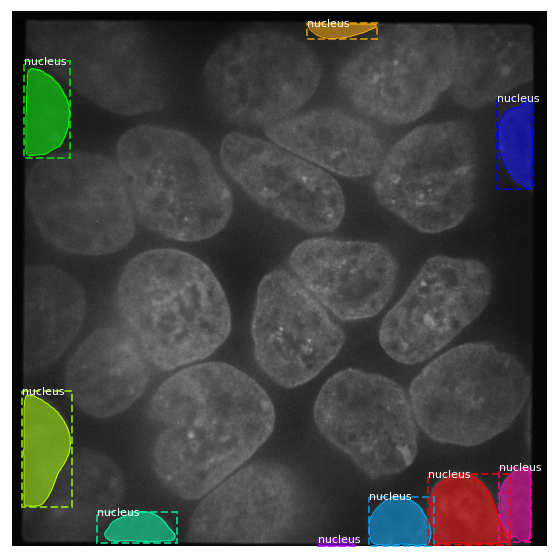

In [61]:
total_masks_area=[]
for i in range(bbox.shape[0]):
    total_masks_area.append(np.sum(mask[:,:,i]))
print("len(total_masks_area): ",len(total_masks_area))

masks_outliers = []
masks_zscore = np.abs(stats.zscore(total_masks_area))
for c in range(bbox.shape[0]):
    masks_outliers.append(((total_masks_area[c])<20000) or (masks_zscore[c]>2.5))

print("masks_outliers: ")
for c in range(len(total_masks_area)):
    if masks_outliers[c]:
        print((masks_outliers[c], c, total_masks_area[c], masks_zscore[c]))
visual_cells(img_dapi, masks_outliers)

### 4.3 remove outliers by boxes_aspect

len(total_boxes_size):  29
boxes_outliers: 
(True, 11, 2.2714285714285714, 2.094230526154438)
(True, 12, 2.5128205128205128, 2.511048742302855)
(True, 22, 2.3271028037383177, 2.190364780110754)
(True, 23, 2.101010101010101, 1.7999641872329024)
total_boxes.shape:  (4, 4)
total_masks.shape:  (1152, 1152, 4)


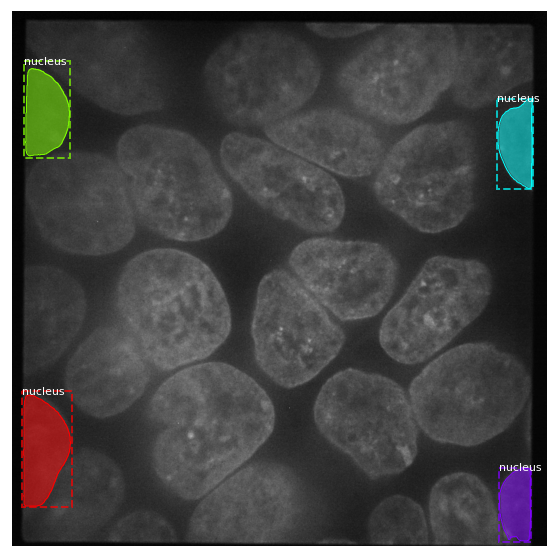

In [62]:
total_boxes_size=[]
for i in range(bbox.shape[0]):
    box = bbox[i]
    total_boxes_size.append((box[2]-box[0])/(box[3]-box[1]))
print("len(total_boxes_size): ",len(total_boxes_size))
    
boxes_outliers = []
boxes_zscore = np.abs(stats.zscore(total_boxes_size))
for zs in boxes_zscore:
    boxes_outliers.append((zs>=1.5))

print("boxes_outliers: ")     
for c in range(len(total_boxes_size)):
    if boxes_outliers[c]:
        print((boxes_outliers[c], c, total_boxes_size[c], boxes_zscore[c]))
visual_cells(img_dapi, boxes_outliers)

### 4.3 All outliers together

total_boxes.shape:  (9, 4)
total_masks.shape:  (1152, 1152, 9)


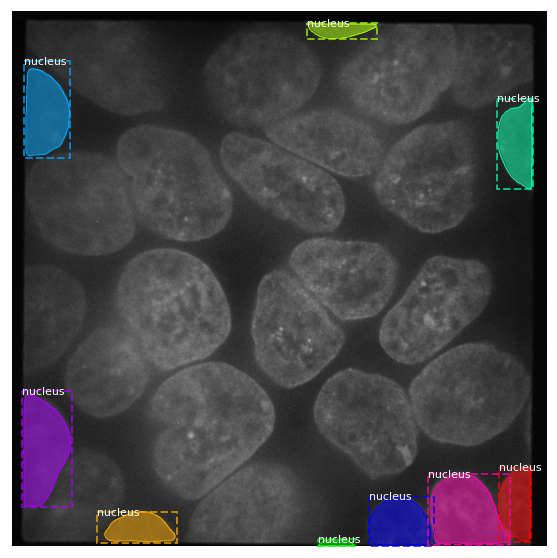

In [63]:
outliers=[]
for i in range(len(masks_outliers)): 
    outliers.append(masks_outliers[i] or roundness_outliers[i] or boxes_outliers[i])
visual_cells(img_dapi, outliers)

total_boxes.shape:  (20, 4)
total_masks.shape:  (1152, 1152, 20)


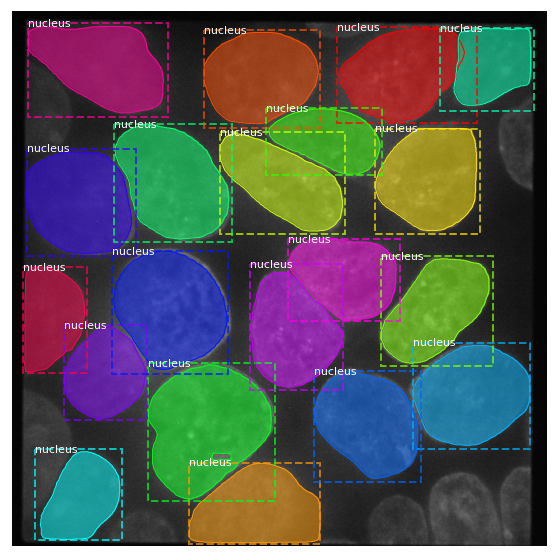

In [64]:
F_total_boxes=[]
F_total_masks=[]
for cc in range(len(outliers)):
    if not outliers[cc]:
        F_total_boxes.append(bbox[cc])
        F_total_masks.append(mask[:,:,cc])

F_total_boxes = np.array(F_total_boxes)
F_total_masks=np.transpose(np.array(F_total_masks),(1,2,0))
F_total_class_ids=np.ones(F_total_boxes.shape[0], dtype=np.int32)
print("total_boxes.shape: ",F_total_boxes.shape)
print("total_masks.shape: ",F_total_masks.shape)
visualize.display_instances(img_dapi, F_total_boxes, F_total_masks, F_total_class_ids, ["BG","nucleus"], figsize=(10,10))

### 4.3 mask processing

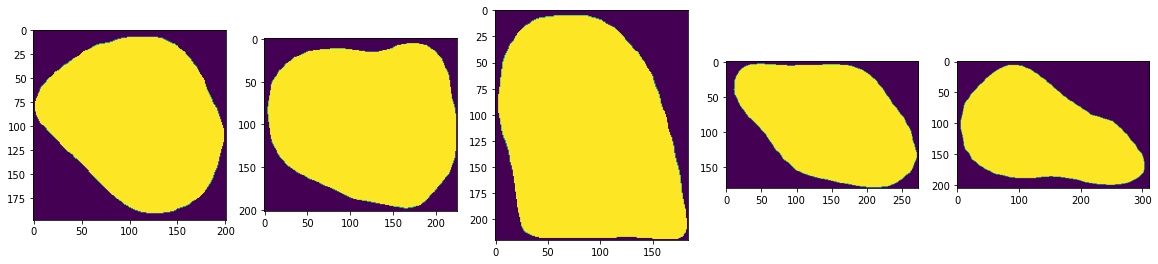

In [21]:
plt.figure(figsize=(20,20))
for nn in range(1, 6):
    bb = F_total_boxes[nn]
    mmask = F_total_masks[:,:,nn][bb[0]:bb[2], bb[1]:bb[3]]

    plt.subplot(1,5,nn)
    plt.imshow(mmask)

# 5. Split Cell 

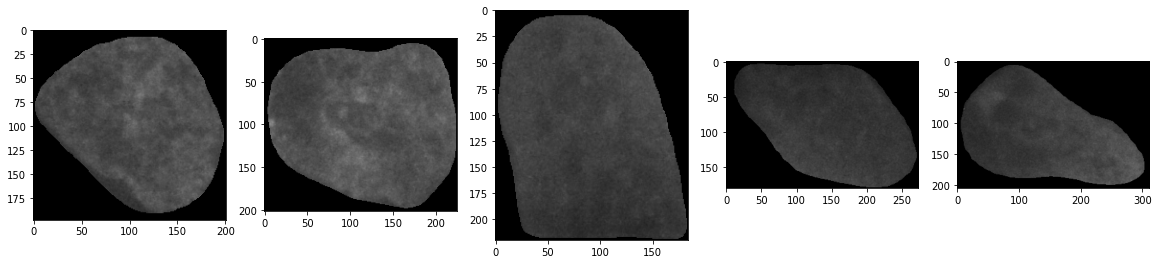

In [22]:
plt.figure(figsize=(20,20))
i = 1
for nn in range(1, 6):
    bb = F_total_boxes[nn]
    mmask = F_total_masks[:,:,nn][bb[0]:bb[2], bb[1]:bb[3]].astype(int)
    mmask = cv2.merge([mmask,mmask,mmask])
    iimg = img_dapi[bb[0]:bb[2], bb[1]:bb[3]]
    iimg = np.multiply(iimg, mmask)
    
    plt.subplot(1,5,i)
    plt.imshow(iimg)
    i = i+1

<class 'numpy.ndarray'> uint8
Save name with  /home/acd13264yb/DDDog/Datasets/240420Rettsyndrome/SingleCell/rett/HPS3042_1_Dapi_488_CTCF_555H3K27AC - Deconvolved 3 iterations, Type Richardson-Lucy_XY01_single00


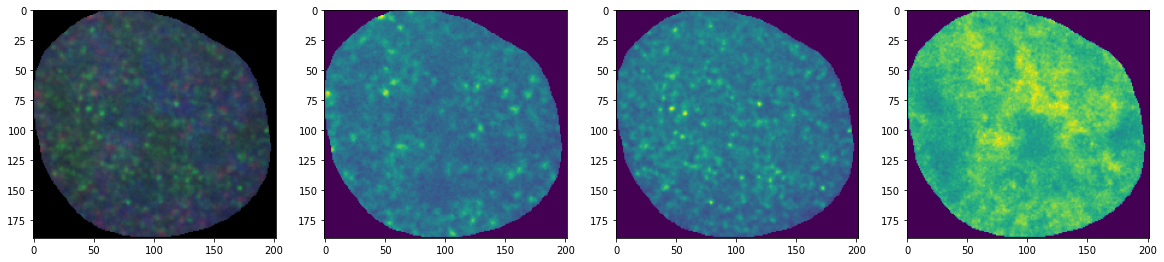

In [49]:
save_cell_path = "/home/acd13264yb/DDDog/Datasets/240420Rettsyndrome/SingleCell/rett/"
imagename="HPS3042_1_Dapi_488_CTCF_555H3K27AC - Deconvolved 3 iterations, Type Richardson-Lucy_XY01.tif"
for nn in range(1):
    bb = F_total_boxes[nn]
    mmask = F_total_masks[:,:,nn][bb[0]:bb[2], bb[1]:bb[3]].astype(np.uint8)
    mmask = cv2.merge([mmask,mmask,mmask])
    iimg = img[bb[0]:bb[2], bb[1]:bb[3]]

    iimg = np.multiply(iimg, mmask)
    rr,gg,bb = cv2.split(iimg)
    print(type(iimg), iimg.dtype, flush=True)
    save_cell_name = f"{save_cell_path}{imagename[:-4]}_single{nn:02}"
    cv2.imwrite(save_cell_name+".tif", iimg)
    cv2.imwrite(save_cell_name+"_H3K27AC.tif", rr)
    cv2.imwrite(save_cell_name+"_CTCF.tif", gg)
    cv2.imwrite(save_cell_name+"_Dapi.tif", bb)
    print("Save name with ", save_cell_name, flush=True)

plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(iimg)

plt.subplot(1,4,2)
plt.imshow(iimg[:,:,0])

plt.subplot(1,4,3)
plt.imshow(iimg[:,:,1])

plt.subplot(1,4,4)
plt.imshow(iimg[:,:,2])

## Install Required Packages

In [101]:
# GPU = True 
# !pip install scikit-image
# !pip install keras==2.2.5
# !pip uninstall -y tensorflow
# if GPU == True:
#     !pip install tensorflow-gpu==1.14
# else:
#     !pip install tensorflow==1.14 

## Download and Install Mask R-CNN

In [ ]:
# # Download Mask R-CNN
# if not os.path.exists('./root/Mask_RCNN'):
#     %cd ./root/
#     !git clone --quiet https://github.com/matterport/Mask_RCNN.git
#     %cd ./Mask_RCNN
# else:
#     %cd ./root/Mask_RCNN

# # Install Mask R-CNN
# !pip install -q PyDrive
# !python setup.py install
# !pip install colorspacious
# if not os.path.exists('./glasbey'):
#     !git clone --quiet https://github.com/taketwo/glasbey.git
# !pip install imagecodecs
# !pip install h5py==2.10.0


# %pwd